In [1]:
#import extra libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from d2l import torch as d2l 
import os
import math
import torch
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class DataManagement(d2l.DataModule):
    def __init__(self, batch_size, train = None, val = None, train_label = None, val_label = None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None: 
            self.raw_train = pd.read_csv('train.csv')
            self.raw_test = pd.read_csv('test.csv')

In [5]:
data = DataManagement(batch_size = 128)

In [6]:
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [7]:
@d2l.add_to_class(DataManagement)
def preprocess(self):
    label = 'label'
    features = pd.concat(
        (self.raw_train.drop(columns = [label]),
         self.raw_test))
    features = features.values.reshape(features.shape[0], 1, 28, 28).astype('float32')
    #print(features)
    ### save preprocessed features
    self.train_label_t = self.raw_train[label]
    self.train_t = features[: self.raw_train.shape[0]].copy()
    self.test = features[self.raw_train.shape[0]:].copy()
    self.train, self.val, self.train_label, self.val_label = train_test_split(self.train_t, self.train_label_t,
                                                                             random_state = 123, 
                                                                             test_size = 0.20, shuffle = False)
    self.train_label = self.train_label.values
    self.val_label = self.val_label.values

In [8]:
data.preprocess()

In [9]:
data.train.shape
print(type(data.val_label))

<class 'numpy.ndarray'>


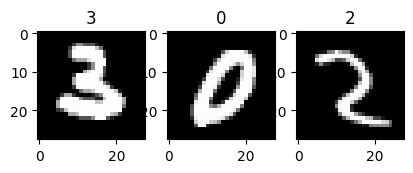

In [10]:

for i in range(10, 13):
    plt.subplot(330 + (i+1))
    plt.imshow(data.val[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(data.val_label[i])

In [11]:
@d2l.add_to_class(DataManagement)
def get_dataloader(self, train):
    data = self.train if train else self.val
    label = self.train_label if train else self.val_label
    label_tensor = torch.tensor(label)
    data_tensor = torch.tensor(data)
    data_tensor = TensorDataset(data_tensor, label_tensor)
    return torch.utils.data.DataLoader(data_tensor, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

In [12]:
#def k_fold_data(data, k):
#    rets = []
#    fold_size = data.train.shape[0] // k
#    for j in range(k):
#        idx = range(j * fold_size, (j+1) * fold_size)
#        #rets.append(idx)
#        rets.append((idx, DataManagement(data.batch_size, np.delete(data.train, idx, 0),
#                                   data.train[idx])))
#        #rets.append(DataManagement(data.batch_size, data.train.drop(index=idx),
#         #                       data.train.loc[idx]))
#    return rets

In [13]:
#def k_fold(trainer, data, k, lr):
#    val_loss, models = [], []
#    for i, (idx, data_fold) in enumerate(k_fold_data(data, k)):
#        print(data_fold.train)
#        data_fold.train_label = np.delete(data.train_label, idx, 0)
#        data_fold.val_label = data.train_label[idx]
#        model = DenseNet(lr)
#        if i != 0: model.board.display = False
#        trainer.fit(model, data_fold)
#        val_loss.append(float(model.board.data['val_loss'][-1].y))
#        models.append(model)
#    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
#    return models

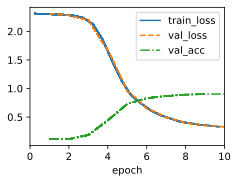

In [14]:
#training the model
#data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer = d2l.Trainer(max_epochs = 10, num_gpus = 1)
#model = k_fold(trainer, data, k = 11, lr = 0.01)
model = d2l.LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [15]:
preds = model(torch.tensor(data.test, dtype=torch.float32)).argmax(axis=1)
print(preds)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
test_preds = torch.LongTensor()
test_preds = torch.cat((test_preds, preds), dim=0)
submission_df = pd.read_csv("sample_submission.csv")
submission_df['Label'] = preds.numpy().squeeze()
submission_df.head()

In [ ]:
submission_df.to_csv('submission.csv', index=False)